In [3]:
#load the data
import csv
import numpy as np

labels = np.load('processing_dataset/labels.npy')
# Extract the onehot encoded labels

spectrograms = np.load("final_dataset/spectrograms.npy")
print("Spectrogramms load finished")

dico_classes = {'02':'Calm',
                '03':'Happy',
                '04':'Sad',
                '05':'Angry',
                '06':'Fearful',
                '07':'Disgust'}

Spectrogramms load finished


In [4]:
# Use the get_dummies function to one-hot encode the labels
import pandas as pd
one_hot = pd.get_dummies(labels)
print(one_hot)


      02  03  04  05  06  07
0      1   0   0   0   0   0
1      1   0   0   0   0   0
2      1   0   0   0   0   0
3      1   0   0   0   0   0
4      0   1   0   0   0   0
...   ..  ..  ..  ..  ..  ..
1127   0   0   0   0   0   1
1128   0   0   0   0   0   1
1129   0   0   0   0   0   1
1130   0   0   0   0   0   1
1131   0   0   0   0   0   1

[1132 rows x 6 columns]


In [6]:
#Split data Train/validation
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split

# Convert the one-hot encoded DataFrame to a tensor
labels = torch.tensor(one_hot.values, dtype=torch.float32)

# split the data into training and validation sets
spectrograms = torch.tensor(spectrograms)

train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(spectrograms, labels, test_size=0.25, random_state=42)

# normalize the spectrograms
train_spectrograms /= 255.0
val_spectrograms /= 255.0

print(val_spectrograms.shape,type(val_spectrograms))

# convert the lists to TensorFlow tensors
train_spectrograms = tf.convert_to_tensor(train_spectrograms, dtype=tf.float32)
val_spectrograms = tf.convert_to_tensor(val_spectrograms, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.int32)

# add a channel dimension to the spectrograms
train_spectrograms = tf.expand_dims(train_spectrograms, axis=-1)
val_spectrograms = tf.expand_dims(val_spectrograms, axis=-1)

print(type(val_spectrograms))

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_16404\4213719864.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrograms = torch.tensor(spectrograms)


torch.Size([283, 128, 549]) <class 'torch.Tensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [16]:
#model creation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_spectrograms.shape[1:],padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(dico_classes), activation='softmax'))

model.summary()




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 549, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 274, 32)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 274, 64)       18496     
                                                                 
 dropout_6 (Dropout)         (None, 64, 274, 64)       0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 137, 64)      0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 280576)           

In [17]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_spectrograms, train_labels, batch_size=32, epochs=15, validation_data=(val_spectrograms, val_labels))

Epoch 1/15
27/27 [==============================] - 87s 3s/step - loss: 2.0435 - accuracy: 0.1802 - val_loss: 1.7926 - val_accuracy: 0.1555
Epoch 2/15
27/27 [==============================] - 89s 3s/step - loss: 1.7645 - accuracy: 0.2309 - val_loss: 1.7219 - val_accuracy: 0.2544
Epoch 3/15
27/27 [==============================] - 92s 3s/step - loss: 1.6336 - accuracy: 0.3274 - val_loss: 1.5664 - val_accuracy: 0.3392
Epoch 4/15
27/27 [==============================] - 94s 3s/step - loss: 1.4323 - accuracy: 0.4193 - val_loss: 1.4030 - val_accuracy: 0.4064
Epoch 5/15
27/27 [==============================] - 93s 3s/step - loss: 1.2286 - accuracy: 0.5088 - val_loss: 1.2210 - val_accuracy: 0.4876
Epoch 6/15
27/27 [==============================] - 87s 3s/step - loss: 1.0681 - accuracy: 0.5760 - val_loss: 1.1177 - val_accuracy: 0.5300
Epoch 7/15
27/27 [==============================] - 85s 3s/step - loss: 0.8388 - accuracy: 0.6996 - val_loss: 1.1855 - val_accuracy: 0.5371
Epoch 8/15
27/27 [==

9/9 [==============================] - 4s 467ms/step


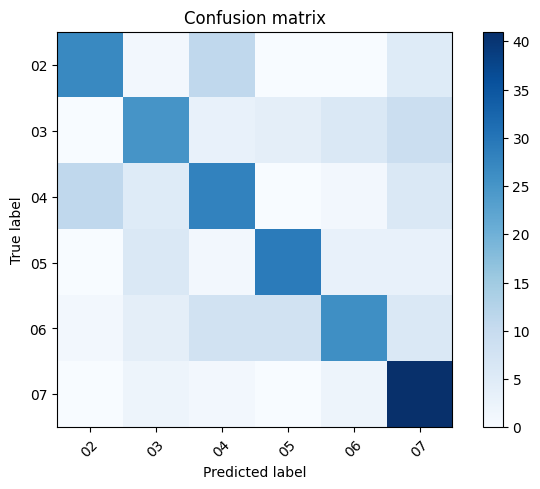

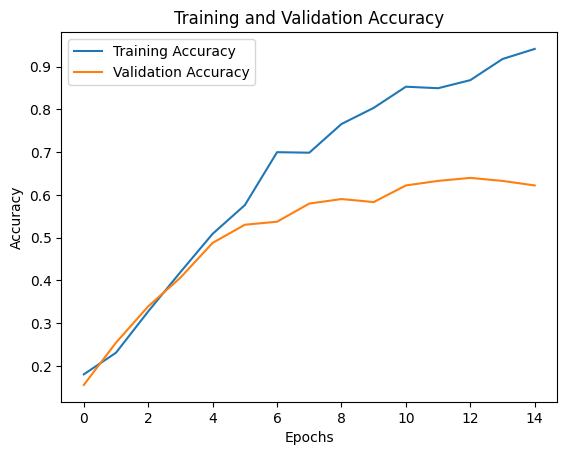

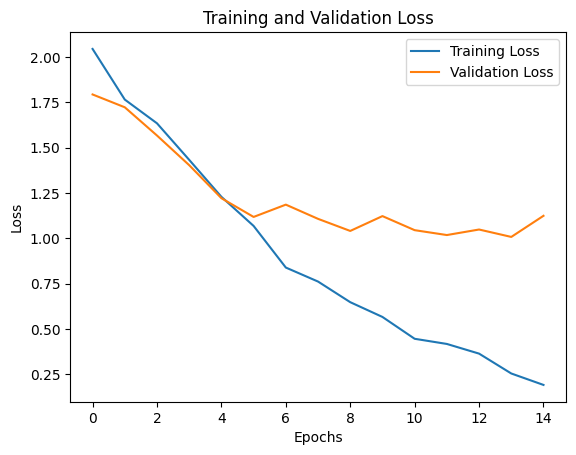

In [18]:
#results and analysis

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predicted labels
pred_labels = np.argmax(model.predict(val_spectrograms), axis=1)

# Convert the one-hot encoded labels to integer labels
val_labels_int = np.argmax(val_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels_int, pred_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(dico_classes))
plt.xticks(tick_marks, dico_classes, rotation=45)
plt.yticks(tick_marks, dico_classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Get the training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a line plot of the training and validation accuracy values
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Create a line plot of the training and validation loss values
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
